In [1]:
import numpy as np
import xarray as xr
import pickle as pk
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import cartopy
from sklearn.metrics import r2_score as r2_score
import cartopy.crs as ccrs
from sklearn.linear_model import LinearRegression as lr 
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rc('font',size=16,**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
def int_alpha(ands,ors):

    intercept = np.zeros([48,96])
    coef = np.zeros([48,96])
    
    for i in range(48):
        for j in range(96):
            intercept[i,j] = lr().fit(ors,ands[:,i,j]).intercept_
            coef[i,j] = -lr().fit(ors,ands[:,i,j]).coef_

    return intercept, coef

In [3]:
#read in step response data
path = '/Volumes/eSSD0/Papers/JoC_gFBK/Data/'
case = ['ctl.2']

    
pi = pk.load(open(path+'SI/b.e12.pi-control.T31_g37.ctl.2_diag_grid.pk','rb'))
p1 = pk.load(open(path+'Outputs/b.e12.1pyCO2.T31_g37.ctl.closed.2_ctl_diag.pk','rb'))
ebp1  = pk.load(open(path+'Outputs/EB/b.e12.1pyCO2.T31_g37.ctl.closed.2_EB_grid.pk','rb'))
ebp1['net'] = ebp1['salb']+ebp1['Planck']+ebp1['lapse']+ebp1['q_tropo']+ebp1['cld_lw']+ebp1['cld_sw']
dp1 = ((p1['TSI']-1360.89)/1360.89)*100

In [4]:
lat = pi['lat']
lon = pi['lon']

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat[:,None],(1,lon.size))

In [5]:
180/len(lat)

3.75

In [6]:
360/len(lon)

3.75

In [7]:
p1intercepts = {}
p1alphas = {}

for terms in ebp1.keys():

    p1intercepts[terms], p1alphas[terms] = int_alpha(ebp1[terms],dp1.reshape(-1,1))

In [8]:
gfbk_gam = {}
gfbk_zm = {}
for keys in p1alphas.keys():
    if p1alphas[keys].ndim != 2:
        pass
    else:
        gfbk_gam[keys] = np.average(p1alphas[keys],weights=coslat)
        gfbk_zm[keys] = np.nanmean(p1alphas[keys], axis=1)

gfbk_gam

{'salb': 0.02384633246886132,
 'ta_strato': 0.3827166296713909,
 'lapse': 0.25130009787762003,
 'Planck': 0.11891548794013045,
 'q_strato': -0.008647290419190745,
 'q_tropo': -0.27455843892070164,
 'cld_lw': -0.061974025443354674,
 'cld_sw': 0.6860598134455087,
 'IRF': -1.1671347984700702,
 'cld_sw_lo': 0.23503168327280022,
 'cld_sw_hi': 0.45102813017270854,
 'cld_lw_lo': -0.029747473329561572,
 'cld_lw_hi': -0.03222655211379311,
 'net': 0.743589267368064}

In [9]:
remap = {}
for keys in gfbk_gam.keys():
    remap[keys] = np.concatenate((p1alphas[keys][:,48:],p1alphas[keys][:,:48]),axis=1)
    remap[keys],lon_cyc = add_cyclic_point(remap[keys],lon)

In [10]:
print(np.amax(remap['cld_sw_hi']),np.amin(remap['cld_sw_hi']))
print(np.amax(remap['cld_sw_lo']),np.amin(remap['cld_sw_lo']))

5.36331566299995 -4.597616776699404
3.686256412399265 -2.6823482863321133


In [11]:
np.amin(remap['cld_sw_hi'])

-4.597616776699404

/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:336: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


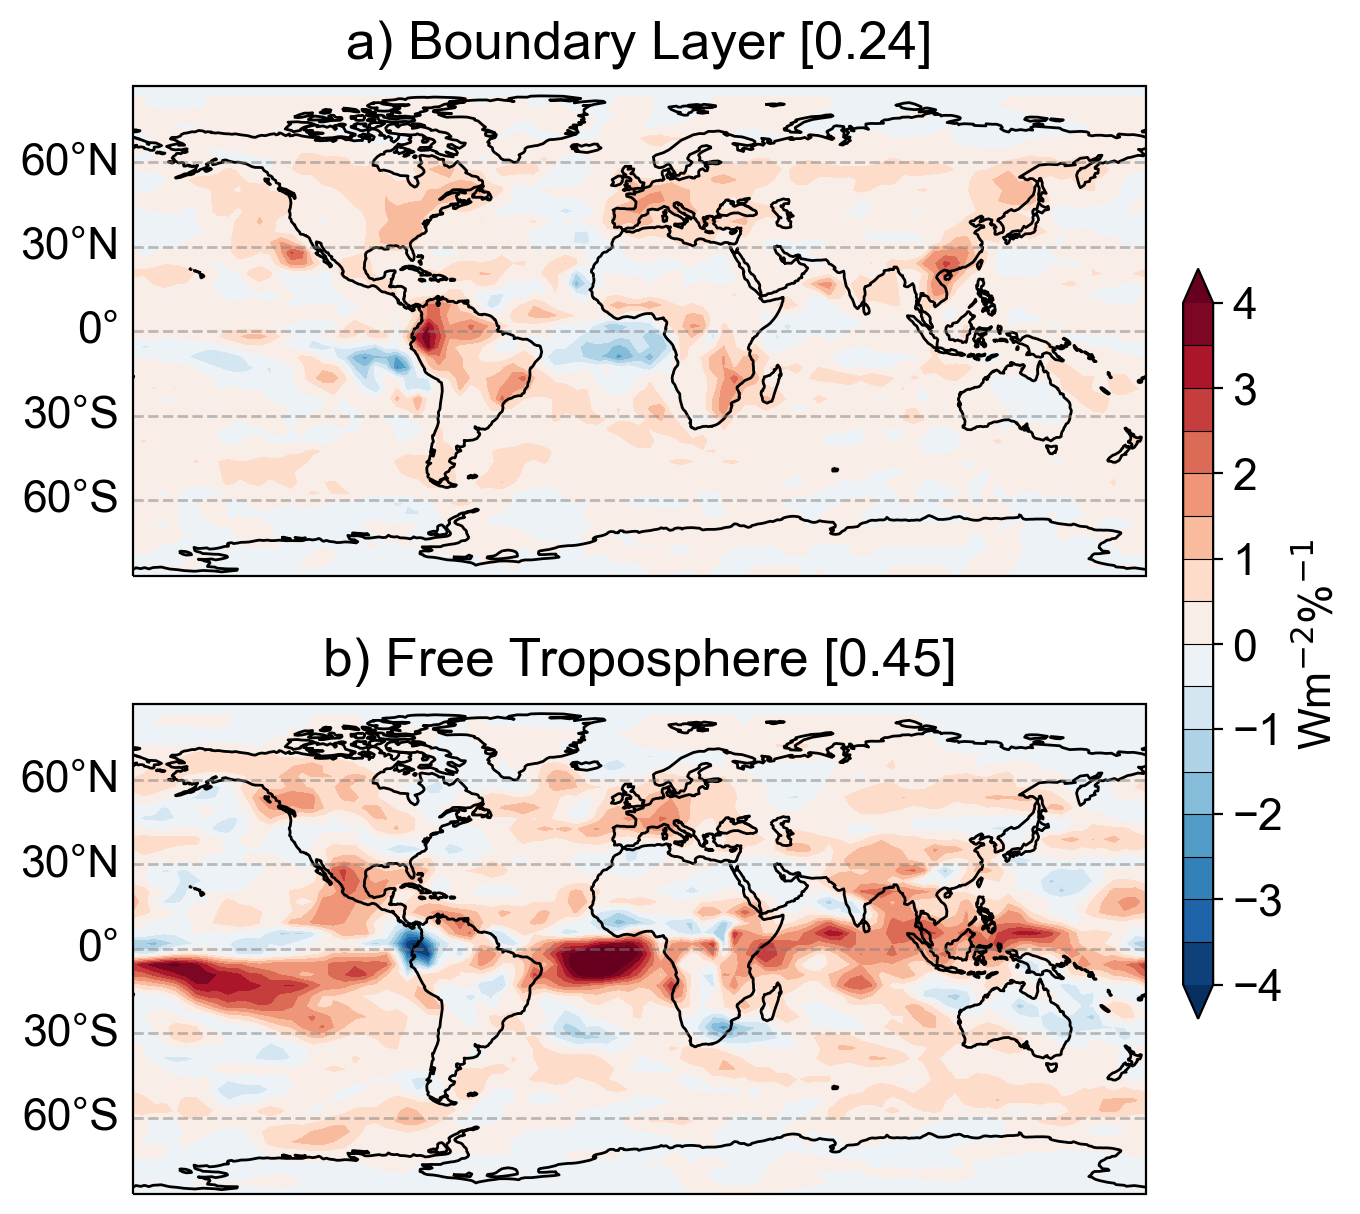

In [12]:
color = plt.cm.RdBu_r

bounds = np.arange(-4,4.1,0.5)

fig = plt.figure(figsize=(7.5,7.5),dpi=200)

#plt.suptitle('Annual Mean')
ax0 = plt.subplot(211,projection=ccrs.PlateCarree())
ax0.set_title(f"a) Boundary Layer [{round(gfbk_gam['cld_sw_lo'],2)}]",pad=10)
#ax0.set_extent([180, -180, -90, 90], ccrs.PlateCarree())
cont0 = ax0.contourf(lon_cyc,lat,remap['cld_sw_lo'],bounds,cmap=color,extend='both',transform=ccrs.PlateCarree(central_longitude=180))
ax0.coastlines()
g1 = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

g1.xlabels_top = False
g1.ylabels_right = False
g1.xlines = False
g1.xlabels_bottom = False
#g1.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
#g1.xformatter = LONGITUDE_FORMATTER
#g1.yformatter = LATITUDE_FORMATTER

ax1 = plt.subplot(212,projection=ccrs.PlateCarree())
ax1.set_title(f"b) Free Troposphere [{round(gfbk_gam['cld_sw_hi'],2)}]",pad=10)
#ax0.set_extent([180, -180, -90, 90], ccrs.PlateCarree())
cont1 = ax1.contourf(lon_cyc,lat,remap['cld_sw_hi'],bounds,cmap=color,extend='both',transform=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines()

g2 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

g2.xlabels_top = False
g2.ylabels_right = False
g2.xlabels_bottom = False
g2.xlines = False

plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.25, 0.02, 0.5])
fig.colorbar(cont0, cax=cbar_ax,drawedges=True,label='Wm$^{-2}$%$^{-1}$', orientation='vertical')

#plt.savefig('gFBK_cldsw_map.png',bbox_inches='tight')


/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:336: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


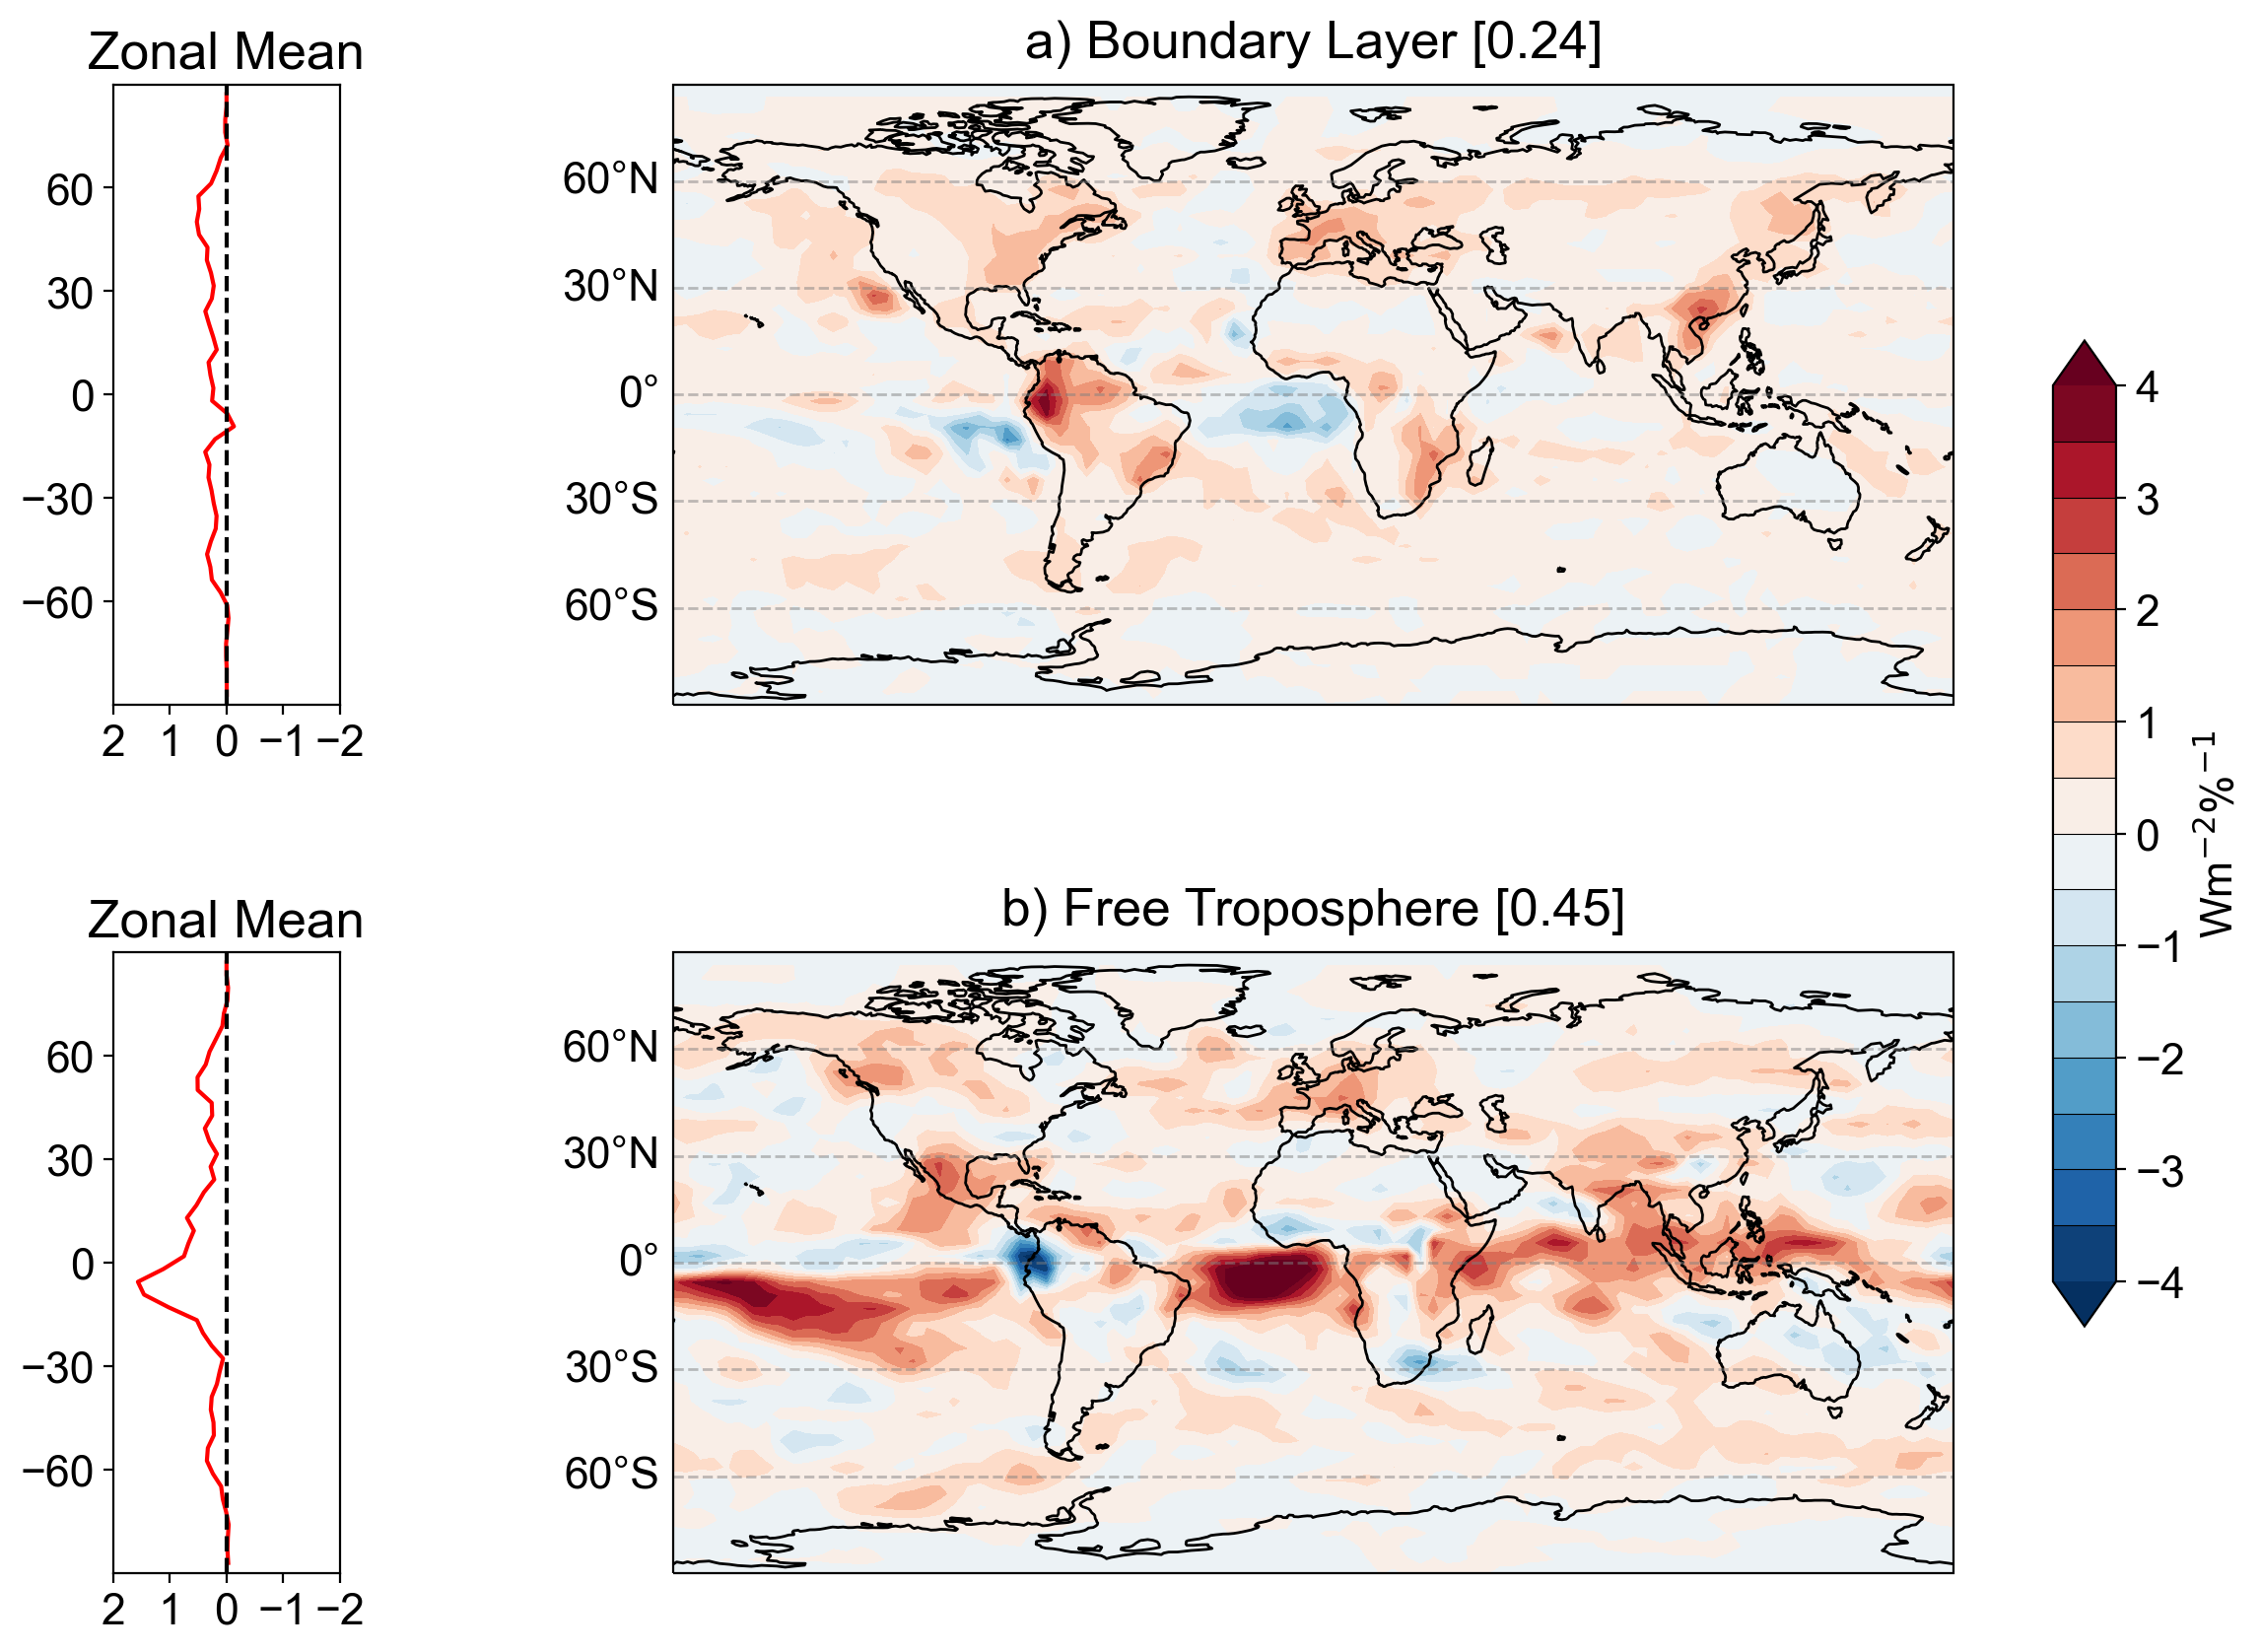

In [13]:
fig = plt.figure(figsize=(16,10),dpi=200)

plt.subplot2grid((2, 8), (0, 0), rowspan=1)
plt.title('Zonal Mean')

plt.plot(gfbk_zm['cld_sw_lo'],lat, color='red')
plt.ylim(-90,90)
plt.xlim(-2,2)
plt.yticks(np.arange(-60,61,30))
plt.xticks(np.arange(-2,2.1,1))
plt.axvline(0,color='k',linestyle='--')
plt.gca().invert_xaxis()

plt.subplot2grid((2, 8), (1, 0), rowspan=1)
plt.title('Zonal Mean')

plt.plot(gfbk_zm['cld_sw_hi'],lat, color='red')
plt.ylim(-90,90)
plt.xlim(-2,2)
plt.yticks(np.arange(-60,61,30))
plt.xticks(np.arange(-2,2.1,1))
plt.axvline(0,color='k',linestyle='--')
plt.gca().invert_xaxis()

ax0 = plt.subplot2grid((2, 8), (0, 1), colspan=7, rowspan=1,projection=ccrs.PlateCarree())
ax0.set_title(f"a) Boundary Layer [{round(gfbk_gam['cld_sw_lo'],2)}]",pad=10)
#ax0.set_extent([180, -180, -90, 90], ccrs.PlateCarree())
cont0 = ax0.contourf(lon_cyc,lat,remap['cld_sw_lo'],bounds,cmap=color,extend='both',transform=ccrs.PlateCarree(central_longitude=180))
ax0.coastlines()
g1 = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

g1.xlabels_top = False
g1.ylabels_right = False
g1.xlines = False
g1.xlabels_bottom = False

ax1 = plt.subplot2grid((2, 8), (1, 1), colspan=7, rowspan=1,projection=ccrs.PlateCarree())
ax1.set_title(f"b) Free Troposphere [{round(gfbk_gam['cld_sw_hi'],2)}]",pad=10)
#ax0.set_extent([180, -180, -90, 90], ccrs.PlateCarree())
cont1 = ax1.contourf(lon_cyc,lat,remap['cld_sw_hi'],bounds,cmap=color,extend='both',transform=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines()

g2 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

g2.xlabels_top = False
g2.ylabels_right = False
g2.xlabels_bottom = False
g2.xlines = False

plt.subplots_adjust(hspace = 0.4,right=0.8)
cbar_ax = fig.add_axes([0.74, 0.25, 0.02, 0.5])
fig.colorbar(cont0, cax=cbar_ax,drawedges=True,label='Wm$^{-2}$%$^{-1}$', orientation='vertical')

plt.savefig('gFBK_cldsw_map.png',bbox_inches='tight')